## Binary Classification on a small Dataset, whether a Person has a high or a low Restingpulse. 
techniques used: 

- logistic regression 
- confussion Matrix 
- Mutual Information and Entropy 
- ROC 

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import math
from matplotlib import pyplot as plt
import pandas as pd 
from scipy.optimize import leastsq, curve_fit
from scipy import linalg

In [2]:
df = pd.read_csv("pulse.txt", delimiter='\t', header=0)#, names=['col1', 'col2', 'col3'])
#print(df.head())

convert = lambda x: 0 if x == "No"  else 1
convert2 = lambda x: 0 if x == "Low"  else 1

df.Smokes = df.Smokes.apply(convert)
df.RestingPulse = df.RestingPulse.apply(convert2)
print(df.head)
print(sum(df.RestingPulse))

<bound method NDFrame.head of     RestingPulse  Smokes  Weight
0              0       0     140
1              0       0     145
2              0       1     160
3              0       1     190
4              0       0     155
..           ...     ...     ...
87             1       1     125
88             0       0     133
89             0       0     110
90             1       0     150
91             0       0     108

[92 rows x 3 columns]>
22


In [3]:
model = LogisticRegression()

X = df[['Smokes', 'Weight']]
Y = df['RestingPulse']

# fit the model to the training data
model.fit(X, Y)

# predict the target variable for the testing data
y_pred = model.predict(X)

tab = np.array(pd.crosstab(y_pred, df.RestingPulse)) #order matters -> x-axis: obs | y-axis: pred
tab[[0, 1]] = tab[[1, 0]] # swap rows and cols for correct interpretation 
tab[:, [0, 1]] = tab[:, [1, 0]]

#print(pd.crosstab(y_pred , df.RestingPulse))
print(tab)

[[ 0  2]
 [22 68]]


TP: RestingPulse is High, and predicted that way 
FP: RestingPulse is High, but predicted low 
FN: RestingPulse is Low, but predicted High
TN: RestingPulse is Low, and predicted that way 

In [4]:
def tab_analysis(tab):
    total = sum(sum(tab))
    TP = tab[0,0]
    FP = tab[0,1]
    FN = tab[1,0]
    TN = tab[1,1]
    
    print("accuray: ", sum(np.diag(tab))/total)
    print("failurerate: ", 1 - sum(np.diag(tab))/total)
    print("true-positive-rate: ", TP/(TP+FN))
    print("false-positive-rate: ", FP/(TN+FP))
    print("specifity: ", 1 - (TP/(TP+FN)))
    print("Percision: ", TP/(TP+FP))
    print("Prevalence: ", (TP+FN)/total)
    
    if sum(tab[:,1]) <= sum(tab[:,0]):
        print("zero-error-rate: ",sum(tab[:,0])/total)
    else:
        print("zero-error-rate: ",sum(tab[:,1])/total)
        
    return ((TP*TN) - (FP*FN))/(math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*TN+FN))

tab_analysis(tab)

accuray:  0.7391304347826086
failurerate:  0.26086956521739135
true-positive-rate:  0.0
false-positive-rate:  0.02857142857142857
specifity:  1.0
Percision:  0.0
Prevalence:  0.2391304347826087
zero-error-rate:  0.7608695652173914


-0.09613910028884337

In [5]:
def mining():
    arr = model.predict_proba(X)
    res = []
    for p in np.arange(0, 1.01, 0.01):
        comp = lambda x: 0 if x[0] >= p else 1 #checks the first col wich corresponds to % of low RP
        preds = np.apply_along_axis(comp, axis=1, arr=arr)
        
        test = pd.crosstab(preds, df.RestingPulse)
        #fill out pontetially empty rows 
        i = test.index.union(test.columns)
        tab = np.array(test.reindex(index=i, columns=i, fill_value=0))
    
        #print(p)   
        tab[[0, 1]] = tab[[1, 0]] 
        tab[:, [0, 1]] = tab[:, [1, 0]]
        
        TP = tab[0,0]
        FP = tab[0,1]
        FN = tab[1,0]
        TN = tab[1,1]
        
        tpr = TP/(TP+FN)
        fpr =  FP/(TN+FP)
        
        res.append((fpr,tpr))  #(x,y)
    
    return res 

roc = mining()

In [6]:
def mining2():
    #now drop weight as a predictor
    model2 = LogisticRegression()

    X = df[['Smokes']]
    Y = df['RestingPulse']

    model2.fit(X, Y)
    arr = model2.predict_proba(X)

    res = []
    for p in np.arange(0, 1.01, 0.01):
        comp = lambda x: 0 if x[0] >= p else 1 #checks the first col wich corresponds to % of low RP
        preds = np.apply_along_axis(comp, axis=1, arr=arr)
        
        test = pd.crosstab(preds, df.RestingPulse)
        #fill out pontetially empty rows 
        i = test.index.union(test.columns)
        tab = np.array(test.reindex(index=i, columns=i, fill_value=0))
    
        #print(p)   
        tab[[0, 1]] = tab[[1, 0]] 
        tab[:, [0, 1]] = tab[:, [1, 0]]
        
        TP = tab[0,0]
        FP = tab[0,1]
        FN = tab[1,0]
        TN = tab[1,1]
        
        tpr = TP/(TP+FN)
        fpr =  FP/(TN+FP)
        
        res.append((fpr,tpr))  #(x,y)
    
    return res 

roc2 = mining2()

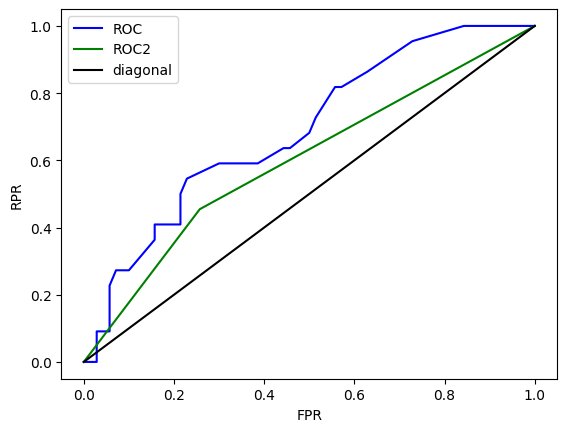

In [7]:
x, y = zip(*roc)
x2, y2 = zip(*roc2)
plt.plot(x,y, label = "ROC", color = "blue")
plt.plot(x2, y2, label = "ROC2", color = "green")
plt.plot(np.arange(0,1.01,0.1),np.arange(0,1.01,0.1), label = "diagonal", color = "black")
plt.xlabel("FPR")
plt.ylabel("RPR")
plt.legend()
plt.show()
#points below the diag are possible 

Since the AUC for the blue curve is greater, then for the green one, we conclude to not drop "weight" as a predictor

## Mutual Information 

Find indipendent Variables, that contribute most to a prediction of a binary outcome 

$$I(X;Y) = \sum_{y \in Y} \sum_{x \in X} p(x,y) \log\frac{p(x,y)}{p(x)p(y)}$$

In a 2x2 Table, the permutations are: (0,0) (0,1) (1,0) (1,1), hence we have 4 summands

* mi = 0, if one of the two variables is constant --> No mutual Information
* $mi \approx 0.5$, if the variables are 100% positively or negatively correlated 

In [16]:
from sklearn.metrics import mutual_info_score

In [21]:
tab = pd.crosstab(df.Smokes, df.RestingPulse, margins = False)
#tab2 = pd.crosstab(df.RestingPulse, df.Smokes, margins = False)
tab

RestingPulse,0,1
Smokes,,
0,52,12
1,18,10


In [23]:
mi = mutual_info_score(tab.values.ravel(), df['Smokes'].value_counts().values.repeat(2), contingency=None)
#mi2 = mutual_info_score(tab2.values.ravel(), df['RestingPulse'].value_counts().values.repeat(2), contingency=None)
#order doesnt matter 
print(mi)
#print(mi2)
#np.corrcoef(df.Smokes,df.RestingPulse)

0.6931471805599452
0.6931471805599452


### Nummeric values 

,RestingPulse,Smokes,Weight,Groups
0,0,0,140,2
1,0,0,145,3
2,0,1,160,3
3,0,1,190,4
4,0,0,155,3


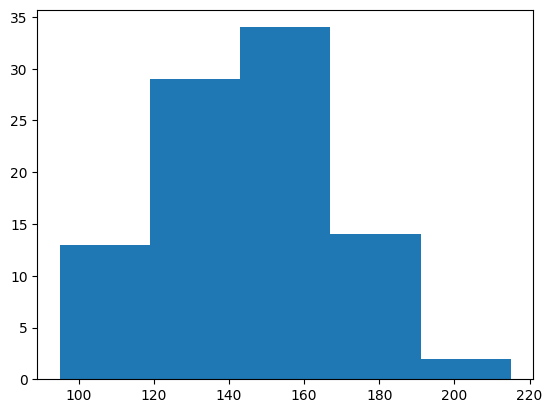

In [36]:
import pandas as pd

# Create a Pandas Series with continuous data
df.Weight
# Bin the data into three groups
bins = plt.hist(df.Weight, bins=5)[1]
labels = ["1","2", "3", "4", "5"]

df["Groups"] = pd.cut(df.Weight, bins=bins, labels=labels)
df.head()


In [54]:
tab2 = pd.crosstab(df.Smokes, df.Groups, margins = False)
#print(tab2)
mi2 = mutual_info_score(tab2.values.ravel(), df['Smokes'].value_counts().values.repeat(5), contingency=None)
print(mi2)

0.5545177444479563


**Note** on computaion 

In [61]:
print(tab2)
print(tab2.values.ravel(), "--> tab values")
print(df['Smokes'].value_counts().values.repeat(5), "--> x-margins")

Weight  (95.0, 119.0]  (119.0, 143.0]  (143.0, 167.0]  (167.0, 191.0]  \
Smokes                                                                  
0                  10              22              23               6   
1                   2               7              11               8   

Weight  (191.0, 215.0]  
Smokes                  
0                    2  
1                    0  
[10 22 23  6  2  2  7 11  8  0] --> tab values
[64 64 64 64 64 28 28 28 28 28] --> x-margins
